In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import DBSCAN
from tqdm import tqdm

In [2]:
df = pd.read_excel("CSV_files/DAS_GoPro_time_correspondence.xlsx")

In [3]:
df.head()

,vid_num,vid_name,vid_duration,time_start,time_end,das_waterfall_start,das_waterfall_end,sec_remain,das_file_start,das_file_end
0,1,GH010442,00:11:47,00:00:00,00:11:47,1,24,0:00:13,sensor_2024-11-23T231921-0800.h5_Start0.0_End30.0,sensor_2024-11-23T233023-0800.h5_Start30.0_End...
1,2,GH020442,00:11:47,00:11:47,00:23:34,24,48,0:00:26,sensor_2024-11-23T233023-0800.h5_Start30.0_End...,sensor_2024-11-23T234224-0800.h5_Start0.0_End30.0
2,3,GH030442,00:11:47,00:23:34,00:35:21,48,71,0:00:09,NaN,NaN
3,4,GH040442,00:11:47,00:35:21,00:47:08,71,95,0:00:22,NaN,NaN
4,5,GH050442,00:11:47,00:47:08,00:58:55,95,118,0:00:05,NaN,NaN


In [4]:
csv_dir = "CSV_files/YOLOv8_tracked_csv"
npy_dir = "DAS_data/"
npy_files = os.listdir(npy_dir)

In [5]:
def name_to_time(file_name):
    file_name = file_name.split("-")
    month = int(file_name[1])
    day, time = file_name[2].split("T")
    day = int(day)
    hour, minute, sec = int(time[:2]), int(time[2:4]), int(time[4:])
    interval = int(file_name[4].split("s")[0])
    start_time = (datetime(2024, month, day, hour, minute, sec), interval)
    return start_time

In [6]:
def normalize(a):
    a = (a - np.min(a))/(np.max(a) - np.min(a))
    return a

def detect_lines(filename, plot=False):
    orig_img = np.flipud(np.load(filename).T)
    img = normalize(orig_img)
    img[img<0.5] = 0
    img = (255*np.stack([img]*3, axis=-1)).astype(np.uint8)
    # Load and process image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Get (x, y) coordinates of all edge pixels
    points = np.column_stack(np.where(edges > 0))  # (y, x)
    points = points[:, ::-1]  # convert to (x, y)

    # Use DBSCAN to cluster edge points
    db = DBSCAN(eps=10, min_samples=20).fit(points)
    labels = db.labels_

    # For visualization
    result = img.copy()
    unique_labels = set(labels)
    detected_edges = []

    for label in unique_labels:
        if label == -1:
            continue  # noise

        cluster_points = points[labels == label]
        x = cluster_points[:, 0]
        y = cluster_points[:, 1]

        if len(x) < 40:
            continue

        # Fit least squares line: y = mx + b
        A = np.vstack([x, np.ones(len(x))]).T
        m, b = np.linalg.lstsq(A, y, rcond=None)[0]

        # Filter only diagonal-ish lines
        if abs(m) < 0.2:
            continue

        # Start/end points for drawing
        x_start, x_end = np.min(x), np.max(x)
        y_start = int(m * x_start + b)
        y_end = int(m * x_end + b)

        cv2.line(result, (x_start, y_start), (x_end, y_end), (0, 0, 255), 2)
        detected_edges.append((label, m, (x_start, y_start), (x_end, y_end)))
        #print(f"[Group {label}] Slope: {m:.2f}, Start: ({x_start}, {y_start}), End: ({x_end}, {y_end})")
        
    if plot:
        # Top: Original image
        plt.subplot(2, 1, 1)
        plt.imshow(orig_img)
        plt.title("Original DAS plot")

        # Bottom: Result image
        plt.subplot(2, 1, 2)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title("Detected Diagonal Lines")
        plt.show()
        
    return detected_edges

In [7]:
time_map = {}
name_map = {}
for file in tqdm(npy_files):
    time = name_to_time(file)
    time_map[time] = os.path.join(npy_dir, file)
    name_map[os.path.join(npy_dir, file)] = time
start_times = sorted(list(time_map.keys()))

100%|███████████████████████████████████| 2334/2334 [00:00<00:00, 153845.64it/s]


In [8]:
start_times

[(datetime.datetime(2024, 11, 23, 23, 19, 21), 30),
 (datetime.datetime(2024, 11, 23, 23, 19, 21), 60),
 (datetime.datetime(2024, 11, 23, 23, 20, 21), 30),
 (datetime.datetime(2024, 11, 23, 23, 20, 21), 60),
 (datetime.datetime(2024, 11, 23, 23, 21, 21), 30),
 (datetime.datetime(2024, 11, 23, 23, 21, 21), 60),
 (datetime.datetime(2024, 11, 23, 23, 22, 21), 30),
 (datetime.datetime(2024, 11, 23, 23, 22, 21), 60),
 (datetime.datetime(2024, 11, 23, 23, 23, 21), 30),
 (datetime.datetime(2024, 11, 23, 23, 23, 21), 60),
 (datetime.datetime(2024, 11, 23, 23, 24, 21), 30),
 (datetime.datetime(2024, 11, 23, 23, 24, 21), 60),
 (datetime.datetime(2024, 11, 23, 23, 25, 22), 30),
 (datetime.datetime(2024, 11, 23, 23, 25, 22), 60),
 (datetime.datetime(2024, 11, 23, 23, 26, 22), 30),
 (datetime.datetime(2024, 11, 23, 23, 26, 22), 60),
 (datetime.datetime(2024, 11, 23, 23, 27, 23), 30),
 (datetime.datetime(2024, 11, 23, 23, 27, 23), 60),
 (datetime.datetime(2024, 11, 23, 23, 28, 23), 30),
 (datetime.d

In [9]:
def find_overlapping_track_ids(df, start, end):
    intervals = df.groupby('track_id')['timestamp'].agg(['min', 'max'])
    overlaps = (intervals['min'] <= end) & (start <= intervals['max'])
    overlapping_ids = intervals.index[overlaps].tolist()
    overlapping_rows = df[df['track_id'].isin(overlapping_ids)].copy()

    return overlapping_rows

In [14]:
vid_idx = 0
offset = 0
vid_info = df.iloc[vid_idx]
csv_path = "tracked_{}.csv".format(vid_info["vid_name"])
csv = pd.read_csv(os.path.join(csv_dir, csv_path))
csv = csv[csv.track_id != 1].reset_index(drop = True)
min_rows = csv.loc[csv.groupby('track_id')['timestamp'].idxmin()]
max_rows = csv.loc[csv.groupby('track_id')['timestamp'].idxmax()]
result = pd.concat([min_rows, max_rows]).sort_values(['track_id', 'timestamp']).reset_index(drop=True)
print(vid_info)
arr_length = 586
k = 2
for i, time in enumerate(start_times, start = 1):
    file_name = time_map[time]
    lines = detect_lines(file_name)
    print(file_name)
    vid_elapsed_sec = (i - vid_info["das_waterfall_start"])*30 - offset
    print(i, vid_elapsed_sec, vid_elapsed_sec + 30)
    vehicles = find_overlapping_track_ids(result, vid_elapsed_sec, vid_elapsed_sec + 30)
    if len(vehicles) != 0:
        k -= 1
        print(vehicles)
    if k == 0:
        break

vid_num                                                                1
vid_name                                                        GH010442
vid_duration                                                    00:11:47
time_start                                                      00:00:00
time_end                                                        00:11:47
das_waterfall_start                                                    1
das_waterfall_end                                                     24
sec_remain                                                       0:00:13
das_file_start         sensor_2024-11-23T231921-0800.h5_Start0.0_End30.0
das_file_end           sensor_2024-11-23T233023-0800.h5_Start30.0_End...
Name: 0, dtype: object
DAS_data/FBE_sensor_2024-11-23T231921-0800_0s-30s_10-200Hz.npy
1 0 30
DAS_data/FBE_sensor_2024-11-23T231921-0800_30s-60s_10-200Hz.npy
2 30 60
DAS_data/FBE_sensor_2024-11-23T232021-0800_0s-30s_10-200Hz.npy
3 60 90
DAS_data/FBE_sensor_2024-11-23T232

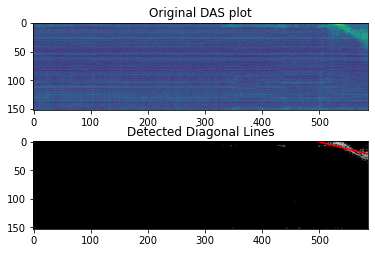

[(0, 0.2663828645872124, (496, 0), (585, 22))]

In [11]:
detect_lines("DAS_data/FBE_sensor_2024-11-23T232021-0800_30s-60s_10-200Hz.npy", plot = True)

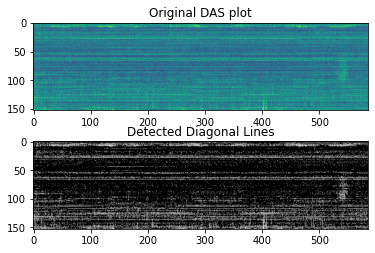

[]

In [17]:
detect_lines("DAS_data/FBE_sensor_2024-11-23T232121-0800_30s-60s_10-200Hz.npy", plot = True)

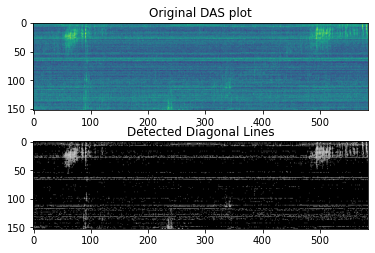

[]

In [16]:
detect_lines("DAS_data/FBE_sensor_2024-11-23T232221-0800_0s-30s_10-200Hz.npy", plot = True)

In [12]:
result

,timestamp,track_id,class_id,confidence
0,172.57,26,2,0.392
1,173.48,26,2,0.175
2,193.17,35,2,0.351
3,193.74,35,2,0.177
4,194.91,37,2,0.685
5,196.61,37,2,0.109
6,243.39,58,2,0.406
7,263.87,58,2,0.107
8,263.74,62,2,0.338
9,353.00,62,2,0.116


In [ ]:
vid_time = [172]
waterfall = []

In [ ]:
496/arr_length + 90